# Real Gas Radiation

This notebook describes the [real gas radiation model](https://github.com/jduffield65/ClimateModel/blob/9fa1cdf7749cddd784c55ead8c3586de56c737ca/Model/radiation/real_gas.py) and goes through some examples of things that can be done with it.

# Model Description
## Flux equations
The difference between this model and the grey gas model is that now the optical depth depends on frequency (or wavenumber $\nu$ here). To derive the model flux equations in this case, we start with equations $(17)$ and $(18)$ from the [grey_radiation notebook](https://github.com/jduffield65/ClimateModel/blob/9fa1cdf7749cddd784c55ead8c3586de56c737ca/grey_radiation.ipynb):

\begin{equation}
\frac{dF^{\uparrow}_{\nu}}{d\tau_{\nu}} = F^{\uparrow}_{\nu} - \pi B(\nu, T)
\label{eq: 1}\tag{1}
\end{equation}

\begin{equation}
\frac{dF^{\downarrow}_{\nu}}{d\tau_{\nu}} = -F^{\downarrow}_{\nu} + \pi B(\nu, T)
\label{eq: 2}\tag{2}
\end{equation}

where:

\begin{equation}
d\tau_{\nu} = -\rho kdz = \frac{k}{g}dp
\label{eq: 3}\tag{3}
\end{equation}

using the hydrostatic equation $\partial p/\partial z = - g\rho$. $k = \sum_{i=0}^n k_iq_i$ where $q_i(z)$ is the specific humidity ($q_i = \rho_i / \rho$). $k_i$ is an absorption coefficient and has units of area per unit mass ($m^2kg^{-1}$). $i$ refers to a particular molecule, $k_i$ depends on wavenumber $\nu$ and pressure $p$ whereas $q_i$ just depends on pressure. Note $\tau_{\nu}$ increases towards the surface and is $0$ at the top of the atmosphere where $p=0$. $B(\nu, T)$ is the blackbody distribution.

By combining the homogenous and particular solutions, the solution to $(1)$ is:


\begin{equation}
F^{\uparrow}_{\nu}(\tau_{\nu}) = F^{\uparrow}_{\nu}(\tau_{\nu}^s)e^{\tau_{\nu} - \tau_{\nu}^s} + 
\int_{\tau_{\nu}}^{\tau_{\nu}^s} \pi B(\nu, T) e^{\tau_{\nu} - \tau_{\nu}'} d\tau_{\nu}'
\label{eq: 4}\tag{4}
\end{equation}

where $\tau_{\nu}^s$ is the optical depth at the surface for wavenumber $\nu$ and we assume [we know the surface flux value](https://github.com/jduffield65/ClimateModel/blob/9fa1cdf7749cddd784c55ead8c3586de56c737ca/Model/radiation/real_gas.py#L568-L569) $F^{\uparrow}_{\nu}(\tau_{\nu}^s)$, i.e. blackbody spectrum of planet surface.

If we then define the [transmission function](https://github.com/jduffield65/ClimateModel/blob/9fa1cdf7749cddd784c55ead8c3586de56c737ca/Model/radiation/real_gas.py#L106-L130) over a wavenumber interval $\Delta \nu$ as a function of two pressures $p_1$ and $p_2$ to be:

\begin{equation}
\mathcal{T}_{\Delta \nu}(p_1, p_2) = \frac{1}{\Delta \nu} \int_{\Delta \nu} e^{\tau_{\nu}(p_1) - \tau_{\nu}(p_2)} d\nu
\label{eq: 5}\tag{5}
\end{equation}

We can then integrate $(4)$ over wavenumber and convert the $\tau$ integral to a $p$ integral to give:

\begin{equation}
F^{\uparrow}_{\Delta \nu}(p) = \frac{1}{\Delta \nu} \int_{\Delta \nu} F^{\uparrow}_{\nu}(p) = F^{\uparrow}_{\nu}(p_s)\mathcal{T}_{\Delta \nu}(p, p_s) - \int_{p}^{p_s} \pi B(\nu, T(p')) \frac{d\mathcal{T}_{\Delta \nu}(p, p')}{dp'} dp'
\label{eq: 6}\tag{6}
\end{equation}

Doing the same for the downward flux, assuming [we know the top of atmosphere flux value](https://github.com/jduffield65/ClimateModel/blob/9fa1cdf7749cddd784c55ead8c3586de56c737ca/Model/radiation/real_gas.py#L570-L573) $F^{\downarrow}_{\nu}(0)$, i.e. blackbody spectrum of star, we get:

\begin{equation}
F^{\downarrow}_{\Delta \nu}(p) = F^{\downarrow}_{\nu}(0)\mathcal{T}_{\Delta \nu}(0, p) + 
\int_{0}^{p} \pi B(\nu, T(p')) \frac{d\mathcal{T}_{\Delta \nu}(p', p)}{dp'} dp'
\label{eq: 7}\tag{7}
\end{equation}

Summing over the wavenumber bands, we get the net flux:

\begin{equation}
F(p) = \sum_{\Delta \nu} \left(F^{\uparrow}_{\Delta \nu}(p) - F^{\downarrow}_{\Delta \nu}(p)\right)\Delta \nu
\label{eq: 8}\tag{8}
\end{equation}

We can then pass this flux into equation $(11)$ of the grey_radiation notebook to compute the evolution of temperature with time. Once the flux has been computed, the rest of the simulation is done in exactly the same way as in the grey gas case.

## Differences to grey model

### Optical depth
To compute the optical depth from real molecules, we need to know the absorption coefficient $k_i$ as a function of wavenumber and pressure. We get this data from [HITRAN](https://hitran.org/). We can get $k_i$ as a functio of pressure, temperature and wavenumber using the Line-by-line data. The functions in [```hitran.py```](https://github.com/jduffield65/ClimateModel/blob/9fa1cdf7749cddd784c55ead8c3586de56c737ca/Model/radiation/real_gas_data/hitran.py) then read in this data and [produce a lookup table](https://github.com/jduffield65/ClimateModel/blob/9fa1cdf7749cddd784c55ead8c3586de56c737ca/Model/radiation/real_gas_data/hitran.py#L306-L343) which contains $k_i(p, T, \nu)$ for the [requested set of pressures and temperatures](https://github.com/jduffield65/ClimateModel/blob/9fa1cdf7749cddd784c55ead8c3586de56c737ca/Model/radiation/real_gas_data/hitran.py#L35-L36). Chapter 4.4 of principles of planetary climate explains this process in more detail.

During a simulation, the absorption coefficients are [read in from these lookup tables](https://github.com/jduffield65/ClimateModel/blob/9fa1cdf7749cddd784c55ead8c3586de56c737ca/Model/radiation/real_gas.py#L87-L93). 

The absorption coefficients for $CO_2$, $CH_4$, $O_3$ and $H_2O$ are shown below for $T = 270K$ and surface pressure.

/Users/joshduffield/Documents/ObjectOrientatedPython/PyCharmTest/venv/lib/python3.8/site-packages/sympl/_core/dataarray.py:6: FutureWarning: xarray subclass DataArray should explicitly define __slots__
  class DataArray(xr.DataArray):


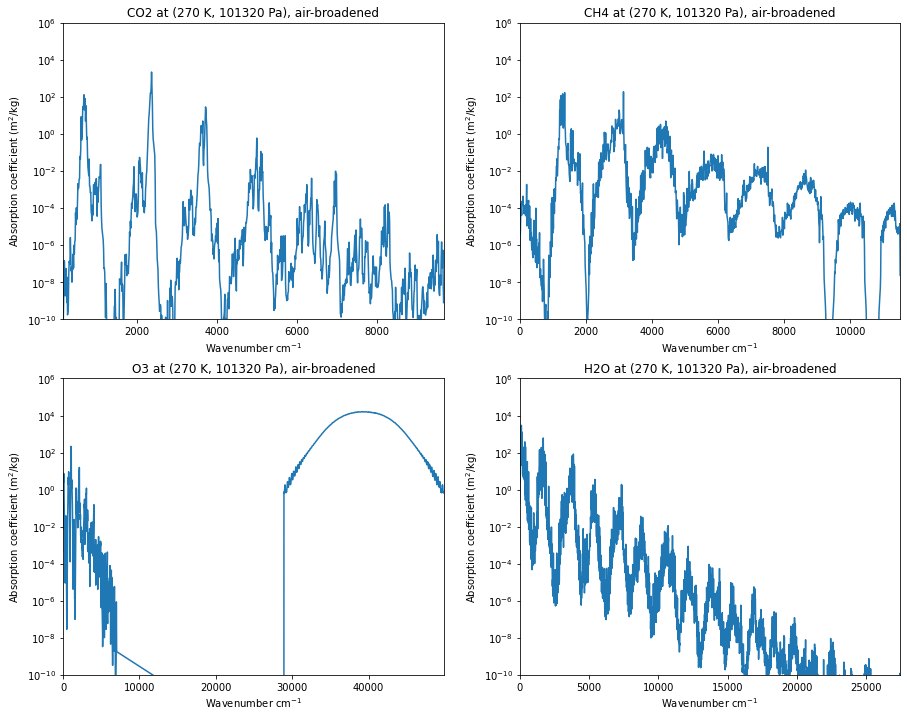

In [1]:
import warnings
warnings.filterwarnings("ignore") # ignore all warnings in this notebook
import matplotlib.pyplot as plt;
import Model.radiation.real_gas_data.hitran as hitran;
import Model.radiation.real_gas_data.specific_humidity as humidity;
from Model.radiation.real_gas import RealGas, transmission;
from IPython.display import HTML;
import numpy as np

p_toa = 0.1  # Top of atmosphere pressure for this notebook (Pa)
fig, axs = plt.subplots(2,2, figsize=(15,12))
hitran.plot_absorption_coefficient('CO2', hitran.p_reference, 270, axs[0,0])
hitran.plot_absorption_coefficient('CH4', hitran.p_reference, 270, axs[0,1])
hitran.plot_absorption_coefficient('O3', hitran.p_reference, 270, axs[1,0])
hitran.plot_absorption_coefficient('H2O', hitran.p_reference, 270, axs[1,1])

To compute the optical depth, we also need the specific humidity distribution for each molecule, $q_i(p)$. To get these I [interporlate from the 2003 curve](https://github.com/jduffield65/ClimateModel/blob/9fa1cdf7749cddd784c55ead8c3586de56c737ca/Model/radiation/real_gas_data/specific_humidity.py) in the plots shown below, which come from a paper by [Stanley C. Solomon](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019JA026678):

<img src="https://agupubs.onlinelibrary.wiley.com/cms/asset/bf9c83ca-c60b-40ff-a32f-97d8425691cc/jgra54943-fig-0001-m.jpg" width="700" height="200" />

These specific humidities are multiplied by the absorption coefficients and a [sum is performed over all molecules selected](https://github.com/jduffield65/ClimateModel/blob/9fa1cdf7749cddd784c55ead8c3586de56c737ca/Model/radiation/real_gas.py#L86-L95).

### Wavenumber bands
To obtain the fluxes from $(6)$ and $(8)$, [we assume](https://github.com/jduffield65/ClimateModel/blob/9fa1cdf7749cddd784c55ead8c3586de56c737ca/Model/radiation/real_gas.py#L516) that within the wavenumber band $\Delta \nu$, that the blackbody spectrum $B(\nu, T)$ is constant. So we must split choose the wavenumber bands in a way that this is roughly satisfied. This is done through the function [```get_wavenumber_bands.py```](https://github.com/jduffield65/ClimateModel/blob/9fa1cdf7749cddd784c55ead8c3586de56c737ca/Model/radiation/real_gas.py#L270-L336) which situates the desired number of bands so that the combined blackbody spectrum from the star and planet (these don't overlap except in the wavenumbers indicated by ```nu_overlap```) changes by about the same amount in each band. 

The function returns a dictionary containing the wavenumbers in a particular band, the central wavenumber (we then calculate $B(\nu, T)$ in each band using this), the wavenumber range and a quantity ```sw```. ```sw``` stands for short wave and it is ```True``` for a band if the wavenumber of that band is beyond the wavenumbers covered by the blackbody radiation of the planet. I.e. for these bands, $B_{planet}(\nu, T_g) = 0$ where $T_g$ is the ground temperature (we assume the ground temperature will be a good guess of the largest temperature encountered in the atmosphere) and so [we can neglect the integrals](https://github.com/jduffield65/ClimateModel/blob/9fa1cdf7749cddd784c55ead8c3586de56c737ca/Model/radiation/real_gas.py#L585-L587) in $(6)$ and $(7)$ for these bands. This is similar to the way I included short wave interaction in the grey radiation example.

### Ground Temperature
In this model, we assume we know the ground temperature, $T_g$ and [calculate the fluxes from it](https://github.com/jduffield65/ClimateModel/blob/9fa1cdf7749cddd784c55ead8c3586de56c737ca/Model/radiation/real_gas.py#L569). However usually, we won't know before hand the value of $T_g$ which will balance the incoming and outgoing fluxes at the top of the atmosphere. In these cases, an initial guess of the ground temperature is found using the function [```initial_Tg_guess```](https://github.com/jduffield65/ClimateModel/blob/9fa1cdf7749cddd784c55ead8c3586de56c737ca/Model/radiation/real_gas.py#L445-L465) which finds $T_g$ such that the sum of the initial net fluxes across all pressure levels is zero. 

A better estimate of $T_g$ can be found using the function [```find_Tg```](https://github.com/jduffield65/ClimateModel/blob/9fa1cdf7749cddd784c55ead8c3586de56c737ca/Model/radiation/real_gas.py#L467-L493) which runs the simulation to equilibrium with a number of different $T_g$ values. It then updates $T_g$ to the value which gives a net flux of approximately zero at the top of the atmosphere.

# Evolution to Equilibrium

Much as with the grey gas example, lets initialise an atmosphere with a single temperature across the entire atmosphere and then evolve until we reach equilibrium. The single temperature here is the surface temperature $T_g$ not the isothermal temperature.

## $CO_2$
Lets start with an atmosphere containing only $CO_2$ with the same specific humidity profile as Earth. First we need to find the surface temperature for this planet. This is done in the cell below. We use only 50 pressure levels to make it run quicker and we only need a rough result.

In the cell afterwards, we can initialise with the correct $T_g$ value and then find the equilibrium temperature profile, much as with the grey gas case.

In [3]:
# Find surface temperature
co2_atmos = RealGas(nz=50, ny=1, molecule_names=['CO2'], p_toa=p_toa, temp_change=1, delta_temp_change=0.5)
T_g_co2 = co2_atmos.find_Tg()

Finding ground temperature to give top of atmosphere flux balance...
Trying T_g = 259.9 K
Trying to reach equilibrium (flux_thresh = 0.1000)...
1 Years, 283 Days: delta_net_flux = 0.0989
Done!
Trying T_g = 260.0 K
Trying to reach equilibrium (flux_thresh = 0.0899)...
0 Years, 86 Days: delta_net_flux = 0.0870
Done!
Trying T_g = 257.6 K
Trying to reach equilibrium (flux_thresh = 0.0577)...
4 Years, 14 Days: delta_net_flux = 0.14501
Done!
Trying T_g = 264.8 K
Trying to reach equilibrium (flux_thresh = 0.0504)...
4 Years, 7 Days: delta_net_flux = 0.171224
Done!


In [2]:
T_g_co2 = 265.19  # answer to previous cell
co2_atmos = RealGas(nz='auto', ny=1, molecule_names=['CO2'], T_g=T_g_co2, p_toa=p_toa, temp_change=1, delta_temp_change=0.5)
flux_dict = {'lw_up': [], 'lw_down': [], 'sw_up': [], 'sw_down': []}
data_co2 = {'t': [], 'T': [], 'flux': flux_dict}
data_co2 = co2_atmos.save_data(data_co2, 0)
data_co2 = co2_atmos.evolve_to_equilibrium(data_co2, flux_thresh=1e-3, t_end=3.0) # run for at most 3 years

Trying to reach equilibrium (flux_thresh = 0.0010)...
3 Years, 1 Days: delta_net_flux = 0.018150
Done!


In [4]:
# get animation
anim_co2 = co2_atmos.plot_animate(data_co2['T'], data_co2['t'], flux_array=data_co2['flux'], nPlotFrames=70); plt.close();
HTML(anim_co2.to_jshtml())

### Transmission plot

The animation shows that temperature decreases as pressure decreases, and we can get more insight for this by looking into the transmission function.

The below plot shows the fraction of radiation emitted by the atmosphere at each pressure level reaches the top of the atmosphere for the most significant wavenumber bands. It clearly shows that all radiation emitted at pressure levels lower than 100 Pa reach the top of the atmosphere. Thus cooling is efficient at these altitudes.

In [55]:
def plot_transmission(atmos, band_indices, direction, combine=False):
    if direction == 'up':
        p1 = atmos.p_interface[:1]
        p2 = atmos.p_interface
        title = 'Transmission to top of atmosphere'
    elif direction == 'down':
        p1 = atmos.p_interface
        p2 = atmos.p_interface[-1:]
        title = 'Transmission to surface'
    p_all = atmos.p_interface
        
    figure, ax = plt.subplots(1,1, figsize = (6, 6))
    for band_ind in band_indices:
        trans = transmission(p1, p2, p_all,
                             atmos.nu_bands['range'][band_ind], atmos.nu_bands['delta'][band_ind],
                             atmos.nu, atmos.tau_interface)
        plt.plot(trans.reshape(-1), atmos.p_interface, label = str(round(atmos.nu_bands['centre'][band_ind])))
    if combine:
        band_range = np.unique(np.concatenate([co2_atmos.nu_bands['range'][i] for i in band_indices]))
        band_delta = band_range[-1] - band_range[0]
        band_centre = band_range[int(len(band_range)/2)]
        trans_combined = transmission(p1, p2, p_all, band_range, band_delta, atmos.nu, atmos.tau_interface)
        plt.plot(trans_combined.reshape(-1), atmos.p_interface, label = 'combined')
    ax.set_ylabel('Emitting pressure level / Pa')
    ax.set_xlabel('Transmission')
    ax.set_title(title)
    ax.set_yscale('log')
    ax.axes.invert_yaxis()
    ax.legend(title=r"$\nu / cm^{-1}$")

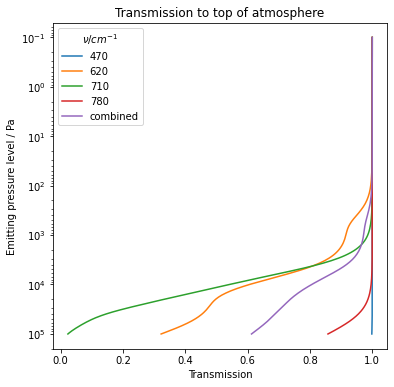

In [64]:
plot_transmission(co2_atmos, np.arange(10, 14), 'up', True)

## $CH_4$

Lets do the same thing with a methane world. 

In [76]:
# Find surface temperature
h2o_atmos = RealGas(nz=50, ny=1, molecule_names=['H2O'], p_toa=p_toa, temp_change=1, delta_temp_change=0.5)
T_g_h2o = h2o_atmos.find_Tg()

Finding ground temperature to give top of atmosphere flux balance...
Trying T_g = 262.4 K
Trying to reach equilibrium (flux_thresh = 0.1000)...
1 Years, 7 Days: delta_net_flux = 0.098238
Done!
Trying T_g = 262.4 K
Trying to reach equilibrium (flux_thresh = 0.0900)...
0 Years, 18 Days: delta_net_flux = 0.0890
Done!
Trying T_g = 251.5 K
Trying to reach equilibrium (flux_thresh = 0.1000)...
0 Years, 184 Days: delta_net_flux = 0.0948
Done!
Trying T_g = 303.6 K
Trying to reach equilibrium (flux_thresh = 0.1000)...
0 Years, 243 Days: delta_net_flux = 0.0814
Done!
Trying T_g = 294.4 K
Trying to reach equilibrium (flux_thresh = 0.1000)...
1 Years, 49 Days: delta_net_flux = 0.07865
Done!
Trying T_g = 296.2 K
Trying to reach equilibrium (flux_thresh = 0.1000)...
2 Years, 332 Days: delta_net_flux = 0.0195
Done!


In [ ]:
T_g_h2o = 296.35 # answer to previous cell
h2o_atmos = RealGas(nz='auto', ny=1, molecule_names=['H2O'], T_g=T_g_h2o, p_toa=p_toa, temp_change=1, delta_temp_change=0.1)
flux_dict = {'lw_up': [], 'lw_down': [], 'sw_up': [], 'sw_down': []}
data_h2o = {'t': [], 'T': [], 'flux': flux_dict}
data_h2o = h2o_atmos.save_data(data_h2o, 0)
data_h2o = h2o_atmos.evolve_to_equilibrium(data_h2o, flux_thresh=1e-3, t_end=3.0) # run for at most 3 years

Trying to reach equilibrium (flux_thresh = 0.0010)...


In [75]:
# get animation
anim_h2o = h2o_atmos.plot_animate(data_h2o['T'], data_h2o['t'], flux_array=data_h2o['flux'], nPlotFrames=70); plt.close();
HTML(anim_h2o.to_jshtml())

## Earth Atmosphere

Now we consider an atmosphere containing average earth humidity profiles for $H_2O$, $CO_2$, $CH_4$ and $O_3$. 

In [ ]:
# Find surface temperature
earth_atmos = RealGas(nz=50, ny=1, molecule_names=['CO2', 'CH4', 'H2O', 'O3'], p_toa=p_toa, temp_change=1, delta_temp_change=0.5)
T_g_earth = earth_atmos.find_Tg()

In [ ]:
T_g_earth = 305
earth_atmos = RealGas(nz='auto', ny=1, molecule_names=['CO2', 'CH4', 'H2O', 'O3'],
                      T_g=T_g_earth, p_toa=0.1, temp_change=1, delta_temp_change=0.05)
flux_dict = {'lw_up': [], 'lw_down': [], 'sw_up': [], 'sw_down': []}
data_earth = {'t': [], 'T': [], 'flux': flux_dict}
data_earth = earth_atmos.save_data(data_earth, 0)
data_earth = earth_atmos.evolve_to_equilibrium(data_earth, flux_thresh=1e-4, t_end=5.0) # run for at most 3 years

In [ ]:
# get animation
anim_earth = earth_atmos.plot_animate(data_earth['T'], data_earth['t'], flux_array=data_earth['flux'], nPlotFrames=100); plt.close();
HTML(anim_earth.to_jshtml())

## With convection

In [ ]:
# Find surface temperature
earth_atmos_conv = RealGas(nz=50, ny=1, molecule_names=['CO2', 'CH4', 'H2O', 'O3'], p_toa=p_toa, temp_change=1, delta_temp_change=0.5)
T_g_earth_conv = earth_atmos.find_Tg(convective_adjust=True)

In [ ]:
T_g_earth_conv = 300
earth_atmos = RealGas(nz='auto', ny=1, molecule_names=['CO2', 'CH4', 'H2O', 'O3'],
                      T_g=T_g_earth_conv, p_toa=0.1, temp_change=1, delta_temp_change=0.05)
flux_dict = {'lw_up': [], 'lw_down': [], 'sw_up': [], 'sw_down': []}
data_earth_conv = {'t': [], 'T': [], 'flux': flux_dict}
data_earth_conv = earth_atmos_conv.save_data(data_earth_conv, 0)
data_earth_conv = earth_atmos_conv.evolve_to_equilibrium(data_earth_conv, flux_thresh=1e-4, t_end=5.0, convective_adjust=True)

In [ ]:
# get animation
anim_earth_conv = earth_atmos_conv.plot_animate(data_earth_conv['T'], data_earth_conv['t'],
                                                flux_array=data_earth_conv['flux'], nPlotFrames=100); plt.close();
HTML(anim_earth_conv.to_jshtml())